In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)

learning_rate = 0.001
batch_size = 128
display_step = 10
plots_outdir="./png"
n_input = 784
n_conv = 7*7*12
n_hidden1 = 600
n_hidden2 = 300
n_hidden3 = 20


x = tf.placeholder(tf.float32, (None, n_input))
x_ = tf.placeholder(tf.float32, (None, n_input))
label_ = tf.placeholder(tf.float32, (None, 10))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
def plotSubset(x_in, x_reconstructed, n=10, cols=None, outlines=True,
               save=True, name="subset", outdir="."):
    """Util to plot subset of inputs and reconstructed outputs"""
    n = min(n, x_in.shape[0])
    cols = (cols if cols else n)
    rows = 2 * int(np.ceil(n / cols)) # doubled b/c input & reconstruction

    plt.figure(figsize = (cols * 2, rows * 2))
    dim = 28 # assume square images

    def drawSubplot(x_, ax_):
        plt.imshow(x_.reshape([dim, dim]), cmap="Greys")
        if outlines:
            ax_.get_xaxis().set_visible(False)
            ax_.get_yaxis().set_visible(False)
        else:
            ax_.set_axis_off()

    for i, x in enumerate(x_in[:n], 1):
        # display original
        ax = plt.subplot(rows, cols, i) # rows, cols, subplot numbered from 1
        drawSubplot(x, ax)

    for i, x in enumerate(x_reconstructed[:n], 1):
        # display reconstruction
        ax = plt.subplot(rows, cols, i + cols * (rows / 2))
        drawSubplot(x, ax)

    plt.show()

#Source: https://github.com/fastforwardlabs/vae-tf/blob/master/plot.py

In [3]:
enc_w1 = tf.get_variable("enc_1", shape=[n_conv + 10, n_hidden1], initializer=tf.contrib.layers.xavier_initializer())
enc_b1 = tf.Variable(tf.zeros(n_hidden1), dtype=tf.float32)
enc_w2 = tf.get_variable("enc_2", shape=[n_hidden1, n_hidden2], initializer=tf.contrib.layers.xavier_initializer())
enc_b2 = tf.Variable(tf.zeros(n_hidden2), dtype=tf.float32)
z_mean_w = tf.get_variable("z_mean_w", shape=[n_hidden2, n_hidden3], initializer=tf.contrib.layers.xavier_initializer())
z_mean_b = tf.Variable(tf.zeros(n_hidden3), dtype=tf.float32)
z_log_sigma_w = tf.get_variable('log_sigma_w', shape=[n_hidden2, n_hidden3], initializer=tf.contrib.layers.xavier_initializer())
z_log_sigma_b = tf.Variable(tf.zeros(n_hidden3), dtype=tf.float32)

In [4]:
dec_w1 = tf.get_variable("dec_1", shape=[n_hidden3 + 10, n_hidden2], initializer=tf.contrib.layers.xavier_initializer())
dec_b1 = tf.Variable(tf.zeros([n_hidden2], dtype=tf.float32))
dec_w2 = tf.get_variable("dec_2", shape=[n_hidden2, n_hidden1], initializer=tf.contrib.layers.xavier_initializer())
dec_b2 = tf.Variable(tf.zeros([n_hidden1], dtype=tf.float32))
dec_w3 = tf.get_variable("dec_3", shape=[n_hidden1, n_input], initializer=tf.contrib.layers.xavier_initializer())
dec_b3 = tf.Variable(tf.zeros([n_input], dtype=tf.float32))

In [5]:
#ENCODING LAYERS, convolutional layers first then labels are added to fully connected layers. 
def conv_layer(input_, filter_, strides_, padding_='SAME', pooling=True):
    weight = tf.Variable(tf.truncated_normal(shape=filter_))
    biases = tf.Variable(tf.zeros(shape=filter_[3]))
    layer = tf.nn.conv2d(input_,weight, strides_,padding_)
    layer = tf.nn.bias_add(layer, biases)
    layer = tf.nn.relu(layer)
    if pooling:
        layer = tf.nn.max_pool(layer, [1,2,2,1], [1,2,2,1], padding='SAME')
    return layer


x_i = tf.reshape(x, shape=[-1, 28, 28, 1])
conv1 = conv_layer(x_i, [5,5,1,6], [1,1,1,1])
conv2 = conv_layer(conv1, [5,5,6,12], [1,1,1,1])
x_in = tf.reshape(conv2, shape=[-1, n_conv])
x_in_lab = tf.concat([x_in, label_], axis=1)


enc_layer_1 = tf.nn.elu(tf.add(tf.matmul(x_in_lab, enc_w1), enc_b1))
enc_layer_2 = tf.nn.elu(tf.add(tf.matmul(enc_layer_1, enc_w2), enc_b2))

z_mean = tf.nn.elu(tf.add(tf.matmul(enc_layer_2, z_mean_w), z_mean_b))
z_log_sigma_sq = tf.nn.elu(tf.add(tf.matmul(enc_layer_2, z_log_sigma_w), z_log_sigma_b))
eps = tf.random_normal(tf.stack([tf.shape(enc_layer_2)[0], n_hidden3]), 0, 1, dtype=tf.float32)

z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
z_cond = tf.concat([z, label_], axis=1)

dec_layer_1 = tf.nn.elu(tf.add(tf.matmul(z_cond, dec_w1), dec_b1))
dec_layer_2 = tf.nn.elu(tf.add(tf.matmul(dec_layer_1, dec_w2), dec_b2))
reconstruction = tf.nn.sigmoid(tf.add(tf.matmul(dec_layer_2, dec_w3), dec_b3))
reconstr_loss = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(reconstruction, x_), 2.0))
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq 
                                  -tf.square(z_mean)
                                  -tf.exp(z_log_sigma_sq), 1)
cost = tf.reduce_mean(reconstr_loss + latent_loss)
optimizer = tf.train.AdamOptimizer().minimize(cost)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


Iteration: 0 cost: 18731577344.000000
Samples:


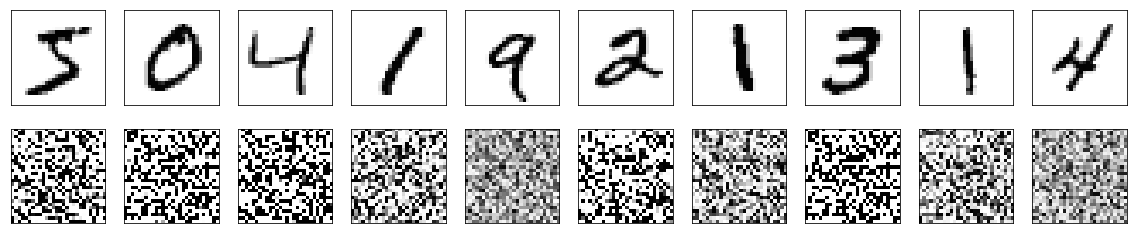

Iteration: 250 cost: 2453.126465
Samples:


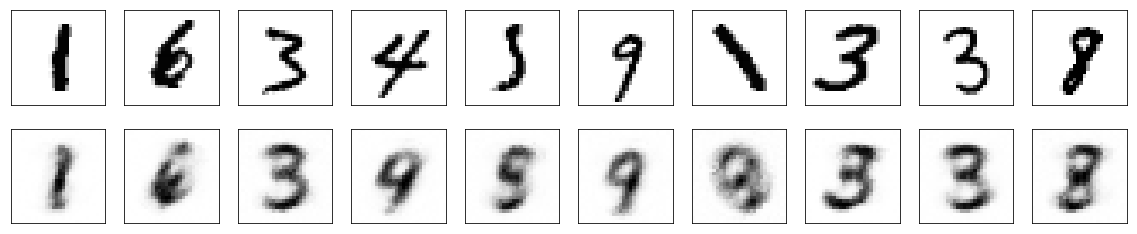

Iteration: 500 cost: 2187.312012
Samples:


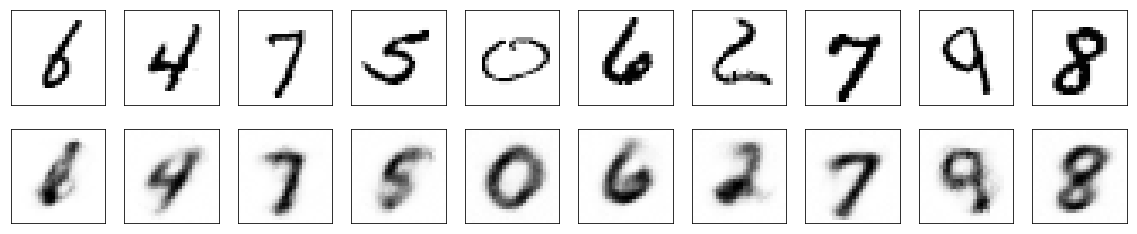

Iteration: 750 cost: 2075.817627
Samples:


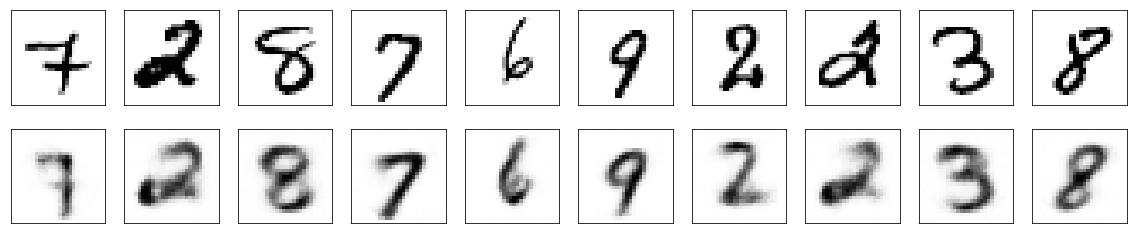

Iteration: 1000 cost: 1953.597412
Samples:


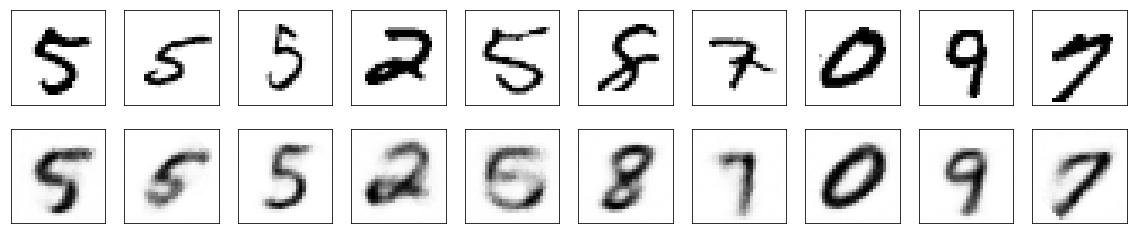

Iteration: 1250 cost: 1914.543701
Samples:


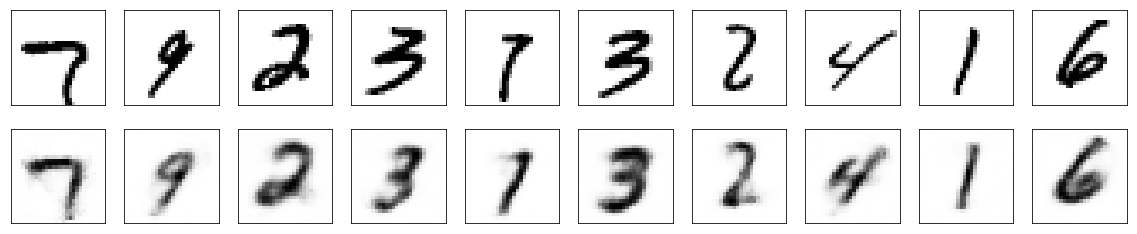

Iteration: 1500 cost: 1773.927246
Samples:


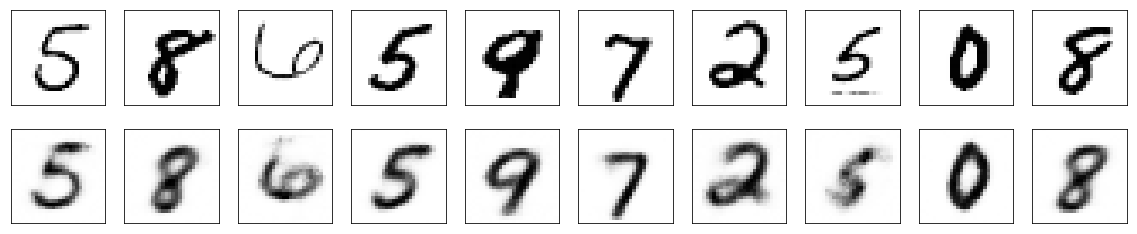

Iteration: 1750 cost: 1835.353760
Samples:


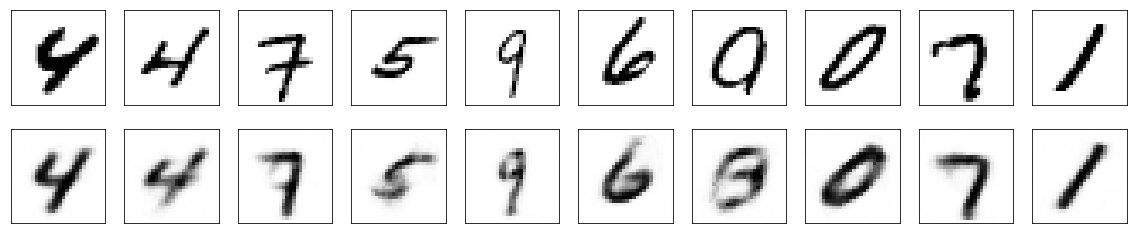

Iteration: 2000 cost: 1718.174683
Samples:


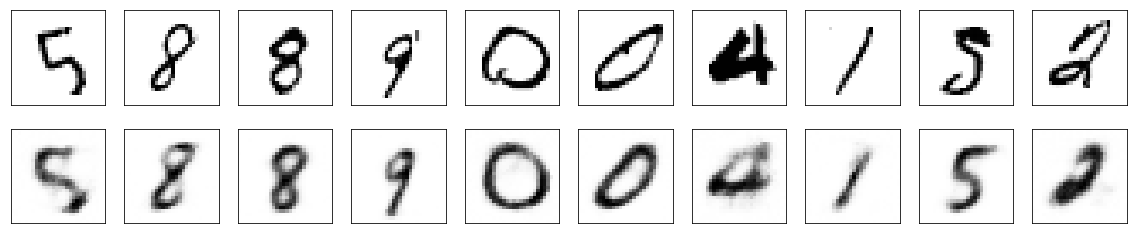

Iteration: 2250 cost: 1618.682373
Samples:


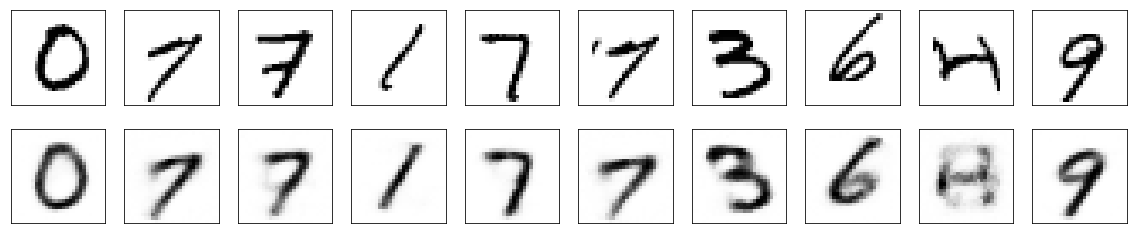

Iteration: 2500 cost: 1667.525269
Samples:


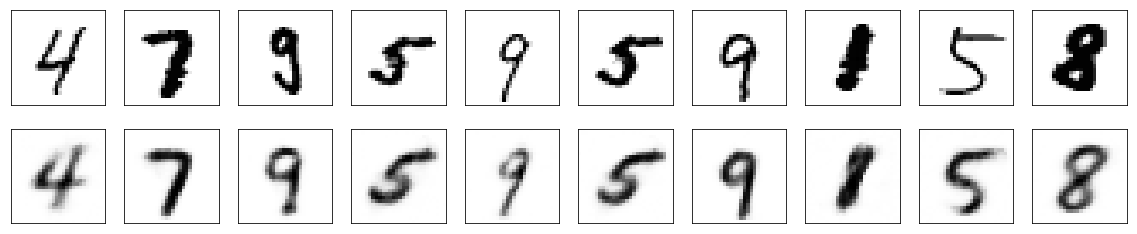

Iteration: 2750 cost: 1682.737183
Samples:


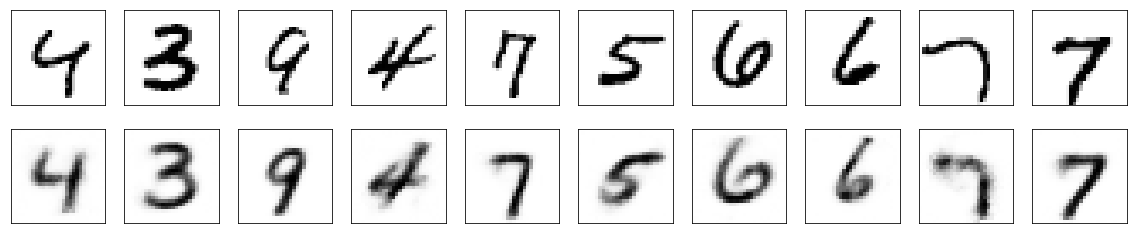

Iteration: 3000 cost: 1742.665894
Samples:


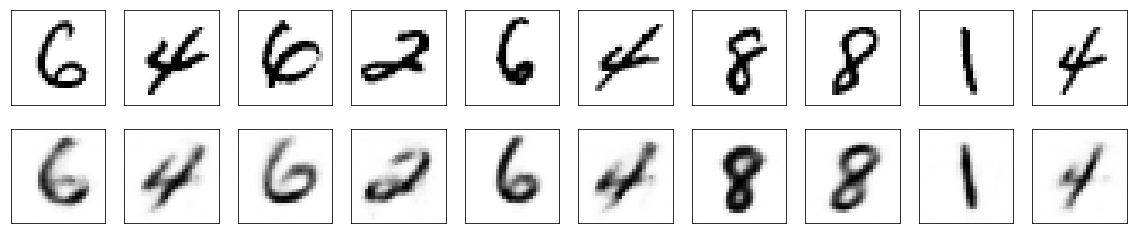

Iteration: 3250 cost: 1574.829224
Samples:


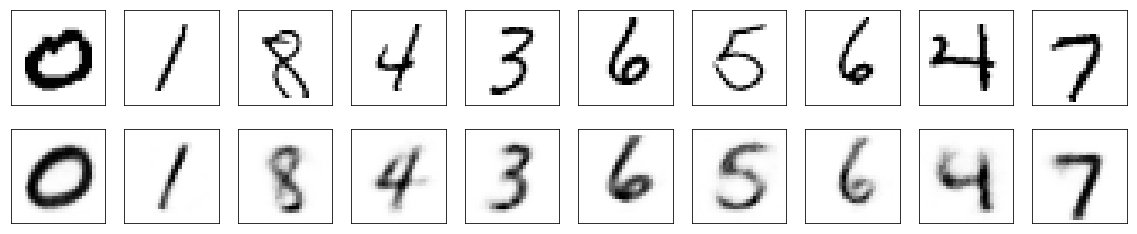

Iteration: 3500 cost: 1545.796509
Samples:


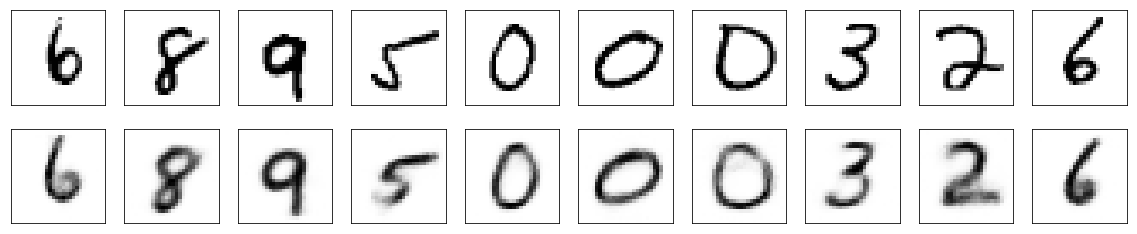

Iteration: 3750 cost: 1660.209839
Samples:


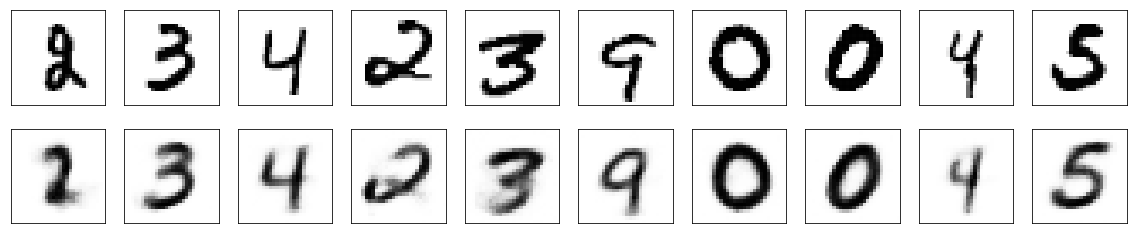

Iteration: 4000 cost: 1628.064453
Samples:


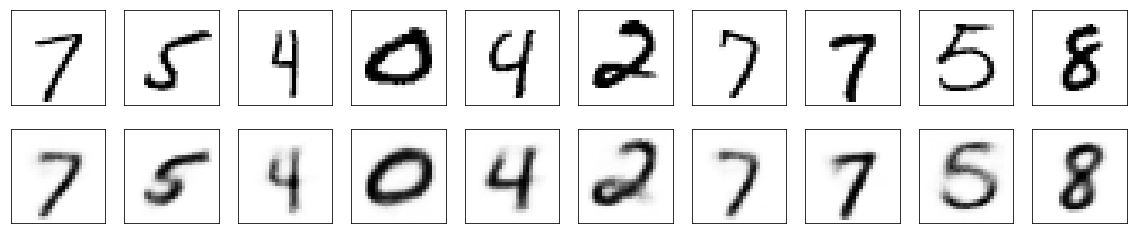

Iteration: 4250 cost: 1735.980713
Samples:


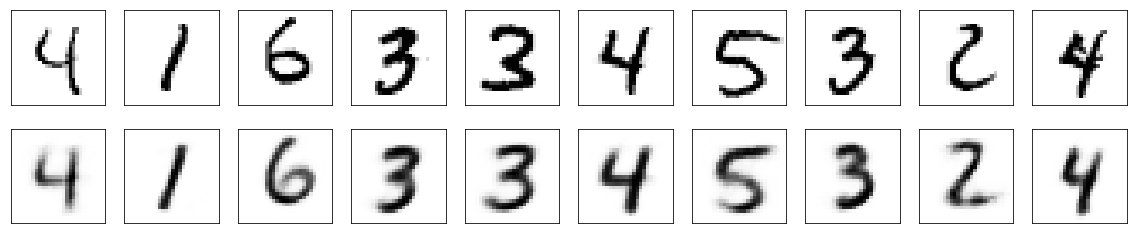

Iteration: 4500 cost: 1442.399292
Samples:


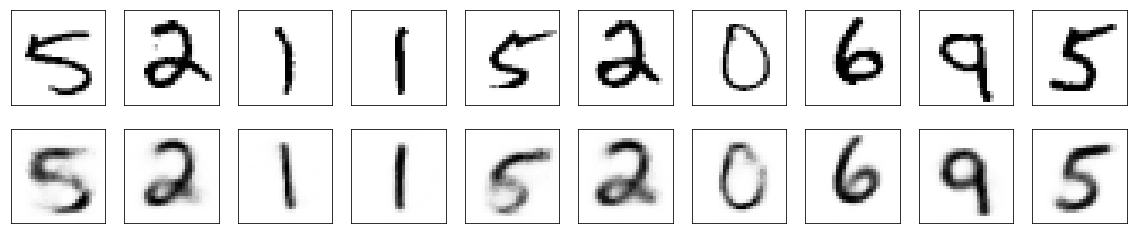

Iteration: 4750 cost: 1570.752808
Samples:


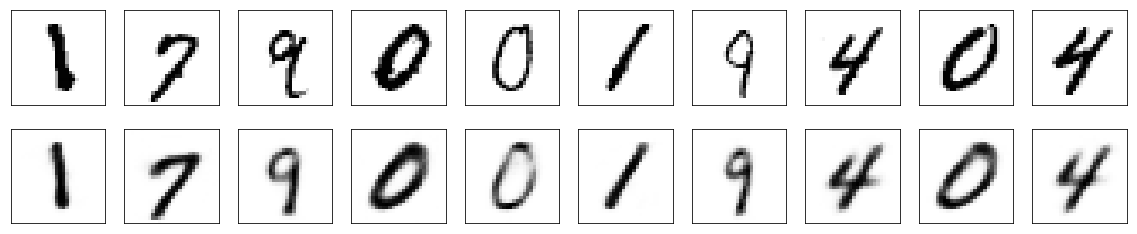

Iteration: 5000 cost: 1481.732788
Samples:


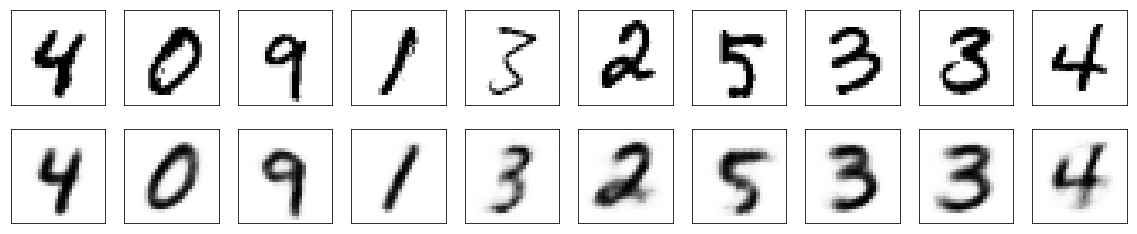

In [6]:
for i in range(5001):
    x1, y1 = mnist.train.next_batch(batch_size)
    _, c = sess.run([optimizer, cost], feed_dict={x: x1, x_:x1, label_: y1})
    if i % 250 == 0:
        print("Iteration: %d cost: %f" %(i, c))

        print("Samples:")

        x2, y2 = mnist.validation.next_batch(batch_size)
        feed_dict2 = {x:x2, x_:x2, label_: y2}
        fetches2 = [reconstruction, cost]
        x_prime2, cost2 = sess.run(fetches2, feed_dict2)
        plotSubset(x2, x_prime2, n=10, name="cv",
                        outdir=plots_outdir)

In [7]:
#conditioning on zero
dig_to_gen = 0
dig_list = np.array([dig_to_gen] * batch_size)
dig_one_hot = np.zeros((batch_size, 10))
dig_one_hot[np.arange(128), dig_list] = 1

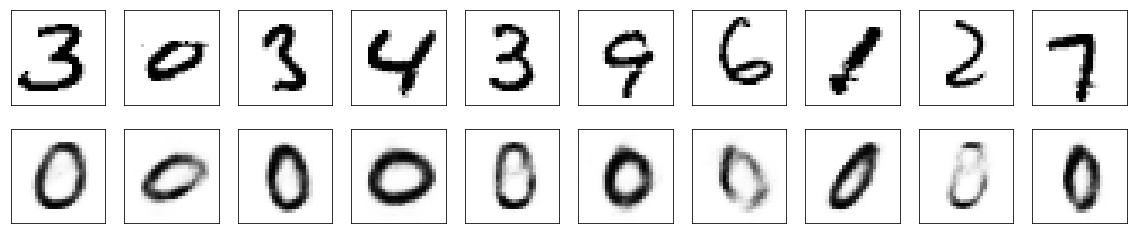

In [9]:
x2, y2 = mnist.validation.next_batch(batch_size)
feed_dict2 = {x:x2, x_:x2, label_: dig_one_hot}
fetches2 = [reconstruction, cost]
x_prime2, cost2 = sess.run(fetches2, feed_dict2)
plotSubset(x2, x_prime2, n=10, name="cv",
                outdir=plots_outdir)